# Fusion DL for Mix-Crystal Pixel (Definitive Edition)
This is python-based code to train the CNN/DL, which is dedicated to dicriminating the fusion cluster introduced from the background \\( K_L^0 \to 3 \pi^0 \\) in \\( K_L^0 \to \pi^0 \gamma \gamma \\) analysis. Because the CSI crystal array of KOTO consists of the small and the large sizes, three types of models based on the geometry are introduced. This is the training script for the mix pixel category (the center crystal is small but some large ones are involved).

### Environment Requirement.
* Jupyter notebook, python3
* Keras, tensorflow, sklearn

### Training Samples
* The selection "fiducial CSI cut + \\( \chi_{shape}^2 < 20 \\) + \\( E_{\gamma} > 50 \\)" is imposed in advance.
* Definition of fusion: Multiple hits were found within 70 mm from the reconstructed photon cluster position.
* Definition of fusion distance: The maximum distance of any two actual hits inside a fusion cluster.
* signal: \\( K_L^0 \to \pi^0 \gamma \gamma \\) GEANT4-based MC without any fusion detected.
* background: \\( K_L^0 \to 3 \pi^0 \\) GEANT4-based MC with **fusion distance > 15 mm**.

### Input data format
* Signal / Background files in .csv structure. Variables of an event are separated by comma.
* 256 x 3 + 3 (+1) variables: e0, t0, s0, e1, t1, s1, ..., e255, t255, s255, cluster E, theta, chisq, (optional: fusion distance), where
    * e0, e1, ..., e255 : energy pixel content ( log(E)/8 )
    * t0, t1, ..., t255 : timing pixel content ( in the unit of 10 ns)
    * s0, s1, ..., s255 : score pixel content (the score varies from 0 to 1 while is crossing through the boundary)
    * cluster energy: log(E) / 8
    * theta = theta / 90
    * chisq = chisq / 20
* The fusion distance is not used for the training but for performance validations.
* Energy / Timing / Score will be converted into the 2-dimensional image (16 x 16 pixel x 3 channels)

### Information
* Author: C. Lin (Jay) [linchieh212@gmail.com], arranged from CSDDL written by Y. C. Tung.
* Date  : Apr. 4, 2020, revised at Apr. 15, 2020


In [21]:
# package import
from __future__ import print_function

# This is for device detection
from tensorflow.python.client import device_lib

# data handling
import numpy
import pandas

# keras
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras import regularizers
from keras.layers import Activation
from keras.models import model_from_json
from keras.layers import Input, Dropout
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.layers.advanced_activations import PReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

# sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os

# if GPU device is detected, it will be listed.
print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6222864908853854532
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13903771769458103573
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14104700298864569376
physical_device_desc: "device: XLA_GPU device"
]


In [22]:
# prepare fundamental parameters for users
prefix="mix_pixel"
base_dir="/data/clin/fusionDL/definitive" 
input_dir=base_dir+"/input"

print("model prefix = ", prefix)
print("input directory = ", input_dir)


random_seed=7
test_ratio=0.3

# start the input loading
print("Prepare data loading. \n")

# Narray is the pixel size
Narray=16

# NCH is the depth of CNN (energy map, timing map, score map)
NCH=3

# extra variables: energy, theta, chisq, (+ fusion distance)
NAdditional=3+1

# total length
eventSize=Narray*Narray*NCH+NAdditional

# read the data from .csv file
print("Load signal data....")
sigFrame = pandas.read_csv(input_dir+"/sigtext/training_cat2.txt", delimiter=",", header=None)
print("Complete signal data loading. \n")
      
print("Load background data....")
bgFrame =  pandas.read_csv(input_dir+"/bgtext/training_cat2.txt", delimiter=",", header=None)
print("Complate background data loading. \n")

# For usrs to check the existance of nan, please uncomment the 2 following statements
# All 0s are expected.
#print("signal data nan? \n",sigFrame.isnull().sum())
#print("background data nan? \n", bgFrame.isnull().sum() )

# numpy representation (array)
sigData = sigFrame.values
bgData = bgFrame.values
print("Signal data shape: ", sigData.shape," and the background data shape: ", bgData.shape )

# extract the valid input data 
sigInput = sigData[ : , 0 : eventSize ]
bgInput = bgData[ : , 0:  eventSize ]
print("Signal input shape: ", sigInput.shape," and the background input shape: ", bgInput.shape )

# extract the number of events in each training samples.
nSigEvt = sigInput.shape[0]
nBgEvt = bgInput.shape[0]
print("Number of signal events: ", nSigEvt,"\nNumber of background events: ", nBgEvt )

# add tag for signal / background
sigTag = numpy.ones( (nSigEvt,1) )
bgTag = numpy.zeros( (nBgEvt,1) )
print("Signal tag shape: ", sigTag.shape," and the background tag shape: ", bgTag.shape )

sigInput = numpy.concatenate( (sigInput, sigTag), axis=1 )
bgInput = numpy.concatenate( (bgInput, bgTag), axis=1 )
print("After adding tags, signal input shape: ", sigInput.shape, " and the background shape: ", bgInput.shape )

inputAll = numpy.concatenate( ( sigInput, bgInput ) )
idAll = numpy.arange(0, inputAll.shape[0] )

print("Concatenation input shape: ", inputAll.shape, " and its ID array shape: ", idAll.shape )

del sigFrame
del bgFrame
del sigData
del bgData

model prefix =  mix_pixel
input directory =  /data/clin/fusionDL/definitive/input
Prepare data loading. 

Load signal data....
Complete signal data loading. 

Load background data....
Complate background data loading. 

Signal data shape:  (362714, 772)  and the background data shape:  (362714, 772)
Signal input shape:  (362714, 772)  and the background input shape:  (362714, 772)
Number of signal events:  362714 
Number of background events:  362714
Signal tag shape:  (362714, 1)  and the background tag shape:  (362714, 1)
After adding tags, signal input shape:  (362714, 773)  and the background shape:  (362714, 773)
Concatenation input shape:  (725428, 773)  and its ID array shape:  (725428,)


In [23]:
# shuffle the data
print("Now shuffle the training data.")
inputAll =  shuffle( inputAll, random_state = random_seed )

# split data into random train and test data
print("Now split the data into random train and test subsets. Ratio of test data = ", test_ratio)
input_train, input_test, id_train, id_test = train_test_split( inputAll, idAll, test_size=test_ratio, random_state=random_seed )
print("Input train size = ", input_train.shape, " input test size = ", input_test.shape)

tag_train=input_train[ : , eventSize: eventSize+1]
tag_test=input_test[ : , eventSize: eventSize+1]
print("Tagging train size = ", tag_train.shape, " Tagging test size = ", tag_test.shape)

Now shuffle the training data.
Now split the data into random train and test subsets. Ratio of test data =  0.3
Input train size =  (507799, 773)  input test size =  (217629, 773)
Tagging train size =  (507799, 1)  Tagging test size =  (217629, 1)


In [24]:
# prepare image input
print('\nPrepare image input')

imageSize=Narray*Narray*NCH
image_train=input_train[ : , 0 : imageSize ]
image_train=image_train.reshape( image_train.shape[0], Narray, Narray, NCH )

image_test=input_test[ : , 0 : imageSize ]
image_test=image_test.reshape( image_test.shape[0], Narray, Narray, NCH )

print("image training shape = ", image_train.shape )
print("image testing shape = ", image_test.shape )

# prepare extra variables input
print("\nPrepare extra variable input")

extraVars_train=input_train[ : , imageSize : eventSize-1 ]
extraVars_test=input_test[ : , imageSize : eventSize-1 ]

print("extra variables training shape = ", extraVars_train.shape )
print("extra variables testing shape = ", extraVars_test.shape )

fusionDist_train=input_train[ : , eventSize-1: eventSize]
fusionDist_test=input_test[ : , eventSize-1: eventSize]

print("fusion distance training shape = ", fusionDist_train.shape )
print("fusion distance testing shape = ", fusionDist_test.shape )


Prepare image input
image training shape =  (507799, 16, 16, 3)
image testing shape =  (217629, 16, 16, 3)

Prepare extra variable input
extra variables training shape =  (507799, 3)
extra variables testing shape =  (217629, 3)
fusion distance training shape =  (507799, 1)
fusion distance testing shape =  (217629, 1)


display the images of the event 0-3.
event 0  signal?  [1.]  vars =  [0.788231 0.157237 0.156931]  , fusion distance =  [-1.]
event 1  signal?  [1.]  vars =  [0.717524 0.173903 0.133676]  , fusion distance =  [-1.]
event 2  signal?  [0.]  vars =  [0.809201 0.179627 0.291864]  , fusion distance =  [32.2344]


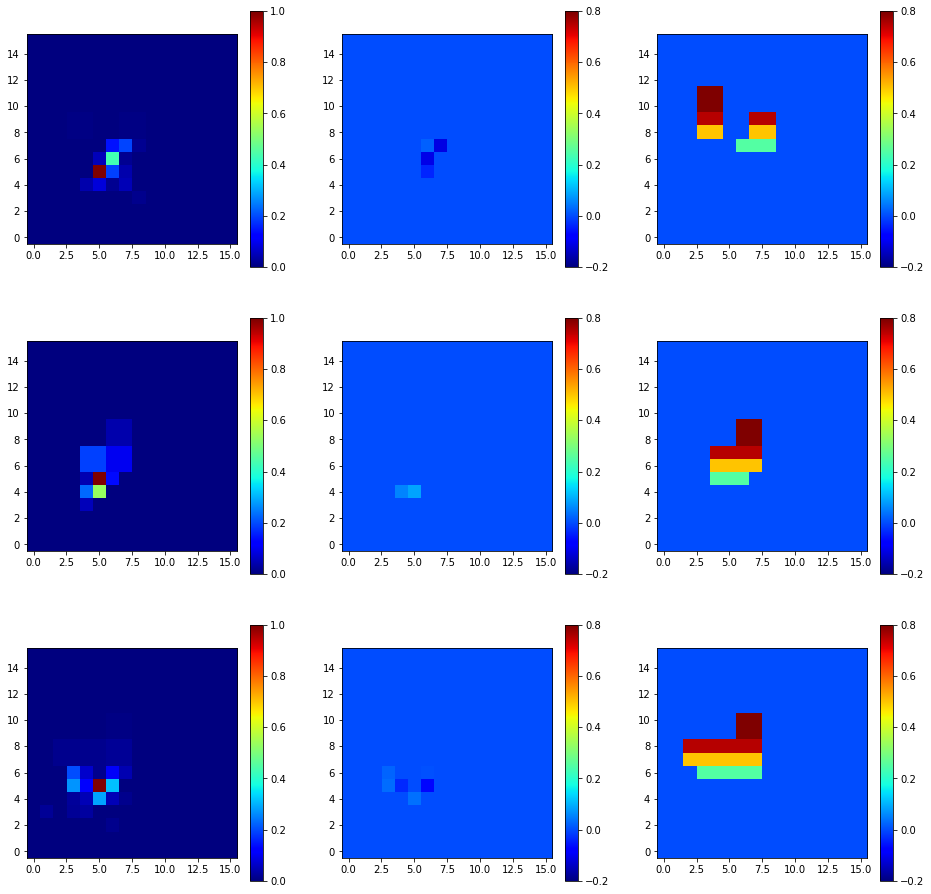

In [25]:
# image display (0-2)
print("display the images of the event 0-3.")
fig1 = plt.figure( 1 , figsize=(16,16) )
    
for i in range(3):
    ax = fig1.add_subplot(3,3,i*3+1)
    plt.imshow(  image_train[ i ,  :  ,  :  ,  0  ], origin='lower', vmin=0., vmax=1.0, cmap="jet"  )
    plt.colorbar()
    
    ax = fig1.add_subplot(3,3,i*3+2)
    plt.imshow(  image_train[  i  ,  :  ,  :  ,  1  ], origin='lower', vmin=-0.2, vmax=0.8, cmap="jet"  )
    plt.colorbar()
    
    ax = fig1.add_subplot(3,3,i*3+3)
    plt.imshow(  image_train[  i  ,  :  ,  :  ,  2  ], origin='lower', vmin=-0.2, vmax=0.8, cmap="jet"  )
    plt.colorbar()
    
    print("event",i," signal? ",tag_train[i]," vars = ", extraVars_train[i], " , fusion distance = ", fusionDist_train[i])

display the images of the event 3-5.
event 3  signal?  [1.]  vars =  [0.795047  0.202884  0.0830239]  , fusion distance =  [-1.]
event 4  signal?  [1.]  vars =  [0.620963 0.292359 0.174168]  , fusion distance =  [-1.]
event 5  signal?  [0.]  vars =  [0.700897 0.274049 0.206334]  , fusion distance =  [78.0404]


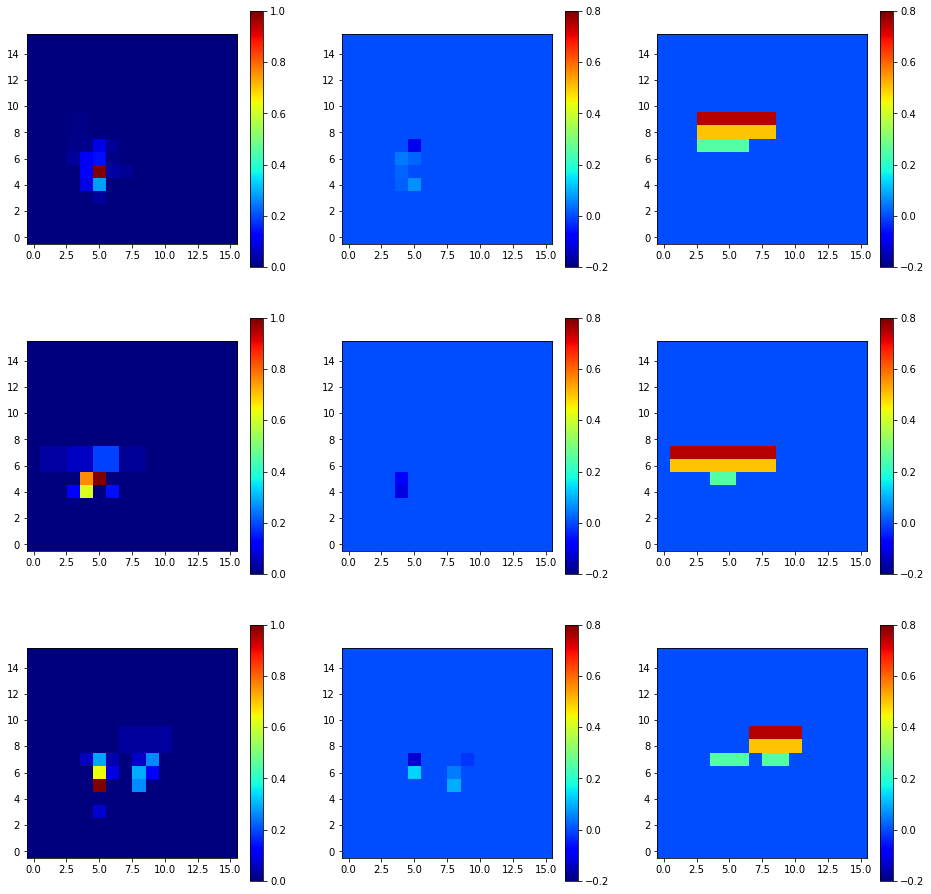

In [26]:
# image display (3-5)
print("display the images of the event 3-5.")
fig1 = plt.figure( 1 , figsize=(16,16) )
    
for j in range(3,6):
    i = j - 3 
    ax = fig1.add_subplot(3,3,i*3+1)
    plt.imshow(  image_train[ j ,  :  ,  :  ,  0  ], origin='lower', vmin=0., vmax=1.0, cmap="jet"  )
    plt.colorbar()
    
    ax = fig1.add_subplot(3,3,i*3+2)
    plt.imshow(  image_train[ j  ,  :  ,  :  ,  1  ], origin='lower', vmin=-0.2, vmax=0.8, cmap="jet"  )
    plt.colorbar()
    
    ax = fig1.add_subplot(3,3,i*3+3)
    plt.imshow(  image_train[  j  ,  :  ,  :  ,  2  ], origin='lower', vmin=-0.2, vmax=0.8, cmap="jet"  )
    plt.colorbar()
    
    print("event",j," signal? ",tag_train[j]," vars = ", extraVars_train[j], " , fusion distance = ", fusionDist_train[j])

display the images of the first 3 events.
event 6  signal?  [0.]  vars =  [0.788341 0.221486 0.591014]  , fusion distance =  [69.8218]
event 7  signal?  [0.]  vars =  [0.801968 0.188665 0.575839]  , fusion distance =  [85.4574]
event 8  signal?  [0.]  vars =  [0.821776 0.140182 0.216577]  , fusion distance =  [57.6598]


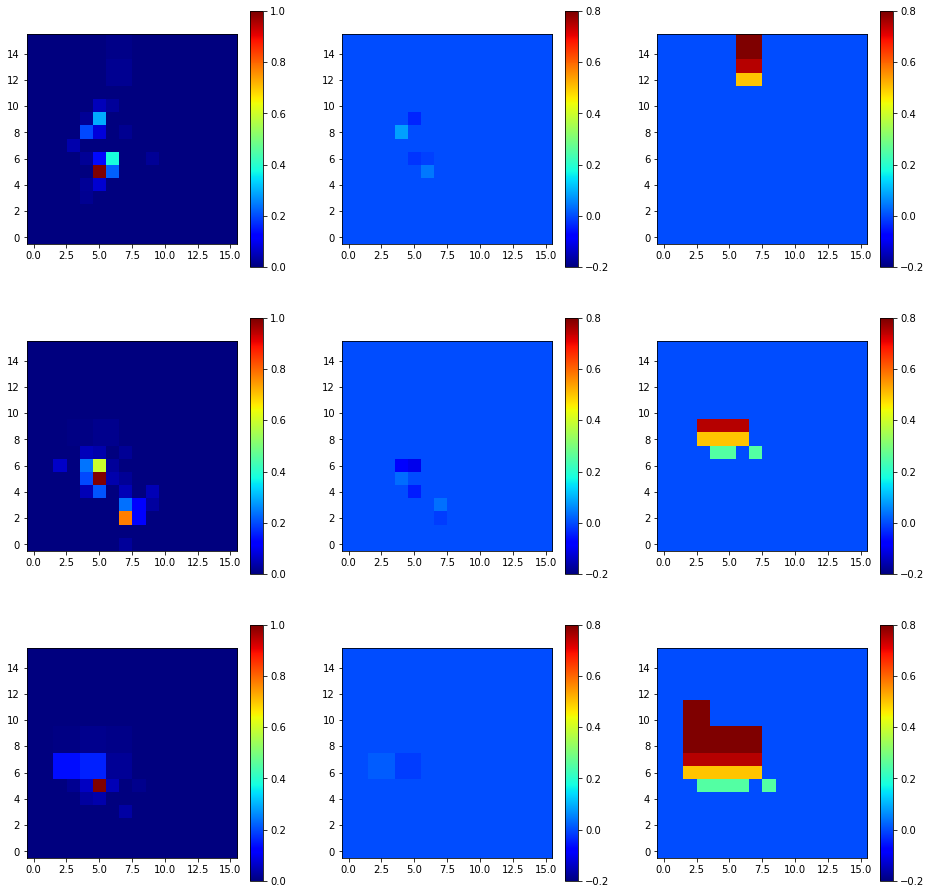

In [27]:
# image display (6-8)
print("display the images of the first 3 events.")
fig1 = plt.figure( 1 , figsize=(16,16) )
    
for j in range(6,9):
    i = j - 6 
    ax = fig1.add_subplot(3,3,i*3+1)
    plt.imshow(  image_train[ j ,  :  ,  :  ,  0  ], origin='lower', vmin=0., vmax=1.0, cmap="jet"  )
    plt.colorbar()
    
    ax = fig1.add_subplot(3,3,i*3+2)
    plt.imshow(  image_train[ j  ,  :  ,  :  ,  1  ], origin='lower', vmin=-0.2, vmax=0.8, cmap="jet"  )
    plt.colorbar()
    
    ax = fig1.add_subplot(3,3,i*3+3)
    plt.imshow(  image_train[  j  ,  :  ,  :  ,  2  ], origin='lower', vmin=-0.2, vmax=0.8, cmap="jet"  )
    plt.colorbar()
    
    print("event",j," signal? ",tag_train[j]," vars = ", extraVars_train[j], " , fusion distance = ", fusionDist_train[j])

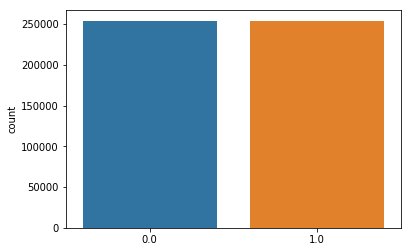

In [28]:
# check the number of signals and backgrounds in training samples
tag_train_reshape = tag_train.reshape( tag_train.shape[0] )
cntplot = sns.countplot(tag_train_reshape)

In [30]:
# convert the input data type for Deep Learning
print("\n Start the input data type conversion.")
input_train = input_train.astype('float32')
input_test  = input_test.astype('float32')
tag_train    = tag_train.astype('float32')
tag_test     = tag_test.astype('float32')


 Start the input data type conversion.


In [31]:
# core of CNN & DL model training
# - For the mix pixel type, overtraining was observed at drop l2val = 0.001
#
l2val=0.001 
drop=0.2

# model constants #
num_classes = 2
neurons=2048
block_size=3
activation='relu'
initial='glorot_uniform'

print("Construct CNN layers")

# CNN layer 1
x0=Input(shape=(Narray,Narray,NCH))
conv1 = Conv2D( 32, kernel_size=(block_size, block_size), kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(x0)
act_conv1 = PReLU()(conv1)

# CNN layer 2
conv2 = Conv2D(32, kernel_size=(block_size, block_size), kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(act_conv1)
act_conv2 = PReLU()(conv2)

# CNN layer 3
conv3 = Conv2D(32, kernel_size=(block_size, block_size), kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(act_conv2)
act_conv3 = PReLU()(conv3)

# CNN layer 4
conv4 = Conv2D(32, kernel_size=(block_size, block_size), kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(act_conv3)
act_conv4 = PReLU()(conv4)

Construct CNN layers


In [32]:
# Flatten to 1-D array
print("Flatten the CNN neurons.")
flat = Flatten()(act_conv4)

# Introduce extra neurons (for extra variables)
print("Introduce extra neurons in the fully-connected layer.")
x1=Input(shape=(NAdditional-1,))
merge = concatenate([flat, x1])

# Fully-connected layer 1
dense1 = Dense(neurons, kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(merge)
act_dense1 = PReLU()(dense1)

# Fully-connected layer 2
dense2 = Dense(neurons, kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(act_dense1)
dropout2 = Dropout(drop)(dense2)
act_dense2 = PReLU()(dropout2)

# Fully-connected layer 3
dense3 = Dense(neurons, kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(act_dense2)
dropout3 = Dropout(drop)(dense3)
act_dense3 = PReLU()(dropout3)

# Fully-connected layer 4
dense4 = Dense(neurons, kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(act_dense3)
dropout4 = Dropout(drop)(dense4)
act_dense4 = PReLU()(dropout4)

# Fully-connected layer 5
dense5 = Dense(neurons, kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(act_dense4)
dropout5 = Dropout(drop)(dense5)
act_dense5 = PReLU()(dropout5)

# Fully-connected layer 6
dense6 = Dense(neurons, kernel_initializer=initial, kernel_regularizer=regularizers.l2(l2val))(act_dense5) 
act_dense6 = PReLU()(dense6)

# Output result
print("Finish construction of model.")
output = Dense(1, activation='sigmoid')(act_dense6)
model = Model(inputs=[x0,x1], outputs=output)
model.summary()

Flatten the CNN neurons.
Introduce extra neurons in the fully-connected layer.
Finish construction of model.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 14, 14, 32)   6272        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 12, 32)   9248        p_re_lu_1[0][0]  

In [34]:
# Fit the model
lr=-5
print("Model fitting with learning rate", 10**lr)
nepochs=50
batch_size=1024
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=10**(lr)),metrics=['accuracy'])
history=model.fit(  [image_train, extraVars_train], tag_train, batch_size=batch_size, epochs=nepochs, verbose=1, \
                       validation_data=([image_test,extraVars_test], tag_test))

Model fitting with learning rate 1e-05
Train on 507799 samples, validate on 217629 samples
Epoch 1/50
507799/507799 [==============================] - 158s 312us/step - loss: 10.0156 - accuracy: 0.7503 - val_loss: 8.2936 - val_accuracy: 0.8767
Epoch 2/50
507799/507799 [==============================] - 156s 307us/step - loss: 7.1471 - accuracy: 0.8873 - val_loss: 6.1236 - val_accuracy: 0.8965
Epoch 3/50
507799/507799 [==============================] - 157s 309us/step - loss: 5.3226 - accuracy: 0.8966 - val_loss: 4.5927 - val_accuracy: 0.9014
Epoch 4/50
507799/507799 [==============================] - 157s 309us/step - loss: 4.0253 - accuracy: 0.9005 - val_loss: 3.5072 - val_accuracy: 0.9041
Epoch 5/50
507799/507799 [==============================] - 155s 305us/step - loss: 3.1062 - accuracy: 0.9037 - val_loss: 2.7391 - val_accuracy: 0.9061
Epoch 6/50
507799/507799 [==============================] - 154s 304us/step - loss: 2.4580 - accuracy: 0.9056 - val_loss: 2.2009 - val_accuracy: 0.9

In [35]:
# Save model to disk
print("Prepare model output (json).")
model_json = model.to_json()

file_path=base_dir+"/model/" + prefix + ".json" 

with open(file_path, "w") as json_file:
   json_file.write(model_json)

file_path=base_dir+"/weight/" + prefix + ".hdf5"
model.save_weights(file_path)

print("Model-saving done.")

Prepare model output (json).
Model-saving done.


In [36]:
# Load back model
print("Prepare model output (json).")
file_path=base_dir+"/model/" + prefix + ".json" 
model_file=base_dir+"/model/" + prefix + ".json"
print("model is located under ", model_file)
    
weight_file=base_dir+"/weight/" + prefix + ".hdf5" 
print("weight file is located under", weight_file)
    
print("Load model and weight files.")
json_file = open( model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
    
model = model_from_json(loaded_model_json)
model.load_weights( weight_file )
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Finish model loading")

Prepare model output (json).
model is located under  /data/clin/fusionDL/definitive/model/mix_pixel.json
weight file is located under /data/clin/fusionDL/definitive/weight/mix_pixel.hdf5
Load model and weight files.
Finish model loading


Plot the epoch history during training.


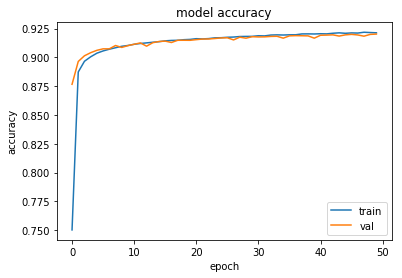

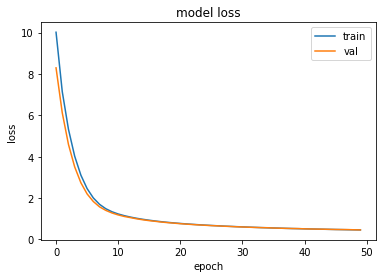

In [37]:
# Plot the epoch history during training
print("Plot the epoch history during training.")

fig = plt.figure()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

file_path=base_dir+"/plot/epoch_accuracy_history_" + prefix + ".pdf" 
fig.savefig(file_path)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

file_path=base_dir+"/plot/epoch_loss_history_" + prefix + ".pdf"
fig.savefig(file_path)

In [38]:
# Apply model prediction
print("Apply model prediction.")
probs_train = model.predict([image_train,extraVars_train],verbose=1)
preds_train = probs_train

fpr_train, tpr_train, threshold_train = metrics.roc_curve(tag_train, preds_train)

probs_test = model.predict([image_test,extraVars_test],verbose=1)
preds_test = probs_test
fpr_test, tpr_test, threshold_test = metrics.roc_curve(tag_test, preds_test)
   
DL_cut=0

print(tpr_test)
for i in range(0,threshold_test.__len__()):
    if tpr_test[i] < 0.90 and tpr_test[i+1] >= 0.90:
        roc_value = 1.0 - fpr_test[i]
        DL_cut = threshold_test[i]
        print(threshold_test[i],fpr_test[i],tpr_test[i])

print("roc_value:", str(roc_value), " DL cut value = ", DL_cut)

Apply model prediction.
217629/217629 [==============================] - 136s 624us/step
[0.00000000e+00 9.18054459e-06 3.48860694e-04 ... 9.99990819e-01
 1.00000000e+00 1.00000000e+00]
0.6947159 0.07349383181696917 0.899996327782164
roc_value: 0.9265061681830309  DL cut value =  0.6947159


Prepare ROC plot


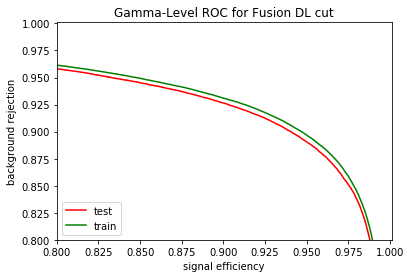

In [39]:
# Plot model ROC
print("Prepare ROC plot")

fig = plt.figure()
plt.title('Gamma-Level ROC for Fusion DL cut')
plt.plot(tpr_test, 1-fpr_test, 'r',label='test')
plt.plot(tpr_train,1-fpr_train, 'green',label='train')
plt.legend(loc = 'lower left')
plt.xlim([0.8, 1.001])
plt.ylim([0.8, 1.001])
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.show()

file_path=base_dir+"/plot/roc_" + prefix + ".pdf" 
fig.savefig(file_path)

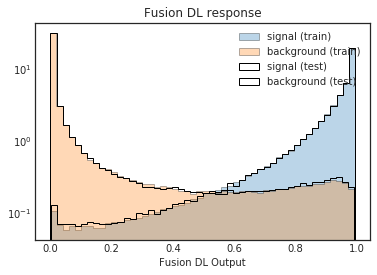

In [50]:
# draw DL response
plt.style.use('seaborn-white')

plt.title("Fusion DL response")

kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=50, ec="k")
plt.hist(preds_train[ tag_train==1 ], **kwargs, label="signal (train)")
plt.hist(preds_train[ tag_train==0 ], **kwargs, label="background (train)")

kwargs = dict(histtype='step', density=True, bins=50, ec="k")
plt.hist(preds_test[ tag_test==1 ], **kwargs, label="signal (test)")
plt.hist(preds_test[ tag_test==0 ], **kwargs, label="background (test)")

plt.xlabel("Fusion DL Output")
plt.legend(loc = 'upper right')

plt.yscale('log', nonposy='clip')
plt.show()

file_path=base_dir+"/plot/DL_response_" + prefix + ".pdf" 
fig.savefig(file_path)

chisq (train) shape (507799, 1)
(507799, 1)


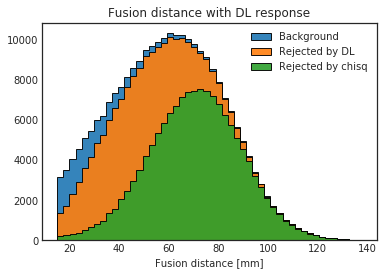

Signal acceptaed efficiency     (DL)    =  0.9019260169905591
Signal acceptaed efficiency     (chisq) =  0.9037464340315539
Background rejection efficiency (DL)    =  0.930109325974072
Background rejection efficiency (chisq) =  0.5613615158398652


In [44]:
# draw fusion distance plot
# - This plot shows how shape chisq / DL cut responds in fusion distance distribution.
# - In principle, DL is able to reject more events than the conventional chisq
#
plt.style.use('seaborn-white')
plt.title("Fusion distance with DL response")

chisq_train = extraVars_train[:,2:3]
chisq_cut=4.3/20
print("chisq (train) shape", chisq_train.shape )
print(preds_train.shape)

kwargs = dict(histtype='stepfilled', alpha=0.9, density=False, bins=50, ec="k")
plt.hist(fusionDist_train[ tag_train==0 ], **kwargs, label="Background")
plt.hist(fusionDist_train[ (tag_train==0) & (preds_train<DL_cut) ], **kwargs, label="Rejected by DL")
plt.hist(fusionDist_train[ (tag_train==0) & (chisq_train>chisq_cut) ], **kwargs, label="Rejected by chisq")

plt.xlabel("Fusion distance [mm]")
plt.legend(loc = 'upper right')
plt.show()

nbg_DL_cut=fusionDist_train[ (tag_train==0) & (preds_train<DL_cut) ].shape[0]
nbg_all=fusionDist_train[ (tag_train==0) ].shape[0]

nsig_DL_cut=fusionDist_train[ (tag_train==1) & (preds_train>DL_cut) ].shape[0]
nsig_all=fusionDist_train[ (tag_train==1) ].shape[0]

nsig_chisq_cut=fusionDist_train[ (tag_train==1) & (chisq_train<chisq_cut) ].shape[0]
nbg_chisq_cut=fusionDist_train[ (tag_train==0) & (chisq_train>chisq_cut) ].shape[0]

print("Signal acceptaed efficiency     (DL)    = ", nsig_DL_cut / nsig_all )
print("Signal acceptaed efficiency     (chisq) = ", nsig_chisq_cut / nsig_all )
print("Background rejection efficiency (DL)    = ", nbg_DL_cut / nbg_all )
print("Background rejection efficiency (chisq) = ", nbg_chisq_cut / nbg_all )

file_path=base_dir+"/plot/bg_fusionDist_" + prefix + ".pdf" 
fig.savefig(file_path)

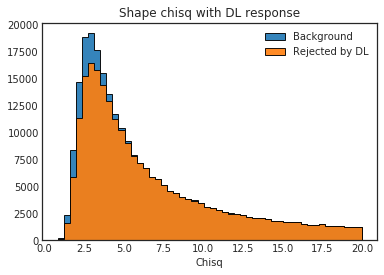

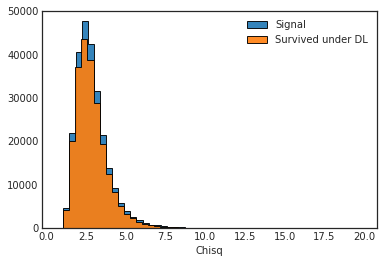

In [45]:
# draw chisq
# - chisq in the input data is already scaled by 1./20, put it back while plotting
# - In principle, the large chisq is prone to be rejected by DL.
#
plt.style.use('seaborn-white')
plt.title("Shape chisq with DL response")

scale=20

kwargs = dict(histtype='stepfilled', alpha=0.9, density=False, bins=50, ec="k")
plt.hist(chisq_train[ tag_train==0 ] * scale, **kwargs, label="Background")
plt.hist(chisq_train[ (tag_train==0) & (preds_train<DL_cut) ] * scale, **kwargs, label="Rejected by DL")
plt.xlabel("Chisq")
plt.legend(loc = 'upper right')
plt.show()
file_path=base_dir+"/plot/bg_chisq_" + prefix + ".pdf" 
fig.savefig(file_path)

plt.hist(chisq_train[ tag_train==1 ] * scale, **kwargs, label="Signal")
plt.hist(chisq_train[ (tag_train==1) & (preds_train>DL_cut) ] * scale, **kwargs, label="Survived under DL")
plt.xlabel("Chisq")
plt.legend(loc = 'upper right')
plt.show()
file_path=base_dir+"/plot/sig_chisq_" + prefix + ".pdf" 
fig.savefig(file_path)

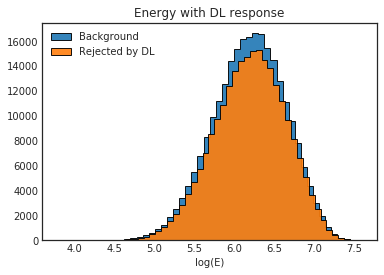

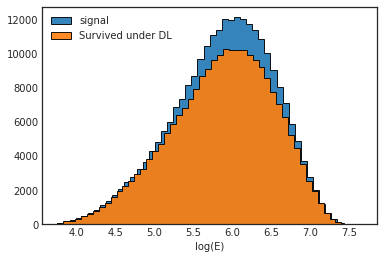

In [46]:
# draw energy
# - This is actually log(energy)
#
plt.style.use('seaborn-white')
plt.title("Energy with DL response")

energy_train=extraVars_train[ : ,0:1]
scale=8

kwargs = dict(histtype='stepfilled', alpha=0.9, density=False, bins=50, ec="k")
plt.hist(energy_train[ tag_train==0 ] * scale, **kwargs, label="Background")
plt.hist(energy_train[ (tag_train==0) & (preds_train<DL_cut) ] * scale, **kwargs, label="Rejected by DL")
plt.xlabel("log(E)")
plt.legend(loc = 'upper left')
plt.show()
file_path=base_dir+"/plot/bg_energy_"+ prefix + ".pdf" 
fig.savefig(file_path)

plt.hist(energy_train[ tag_train==1 ] * scale, **kwargs, label="signal")
plt.hist(energy_train[ (tag_train==1) & (preds_train>DL_cut) ] * scale, **kwargs, label="Survived under DL")
plt.xlabel("log(E)")
plt.legend(loc = 'upper left')
plt.show()
file_path=base_dir+"/plot/sig_energy_" + prefix + ".pdf" 
fig.savefig(file_path)

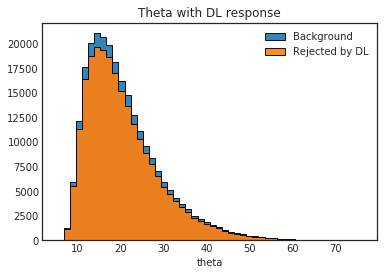

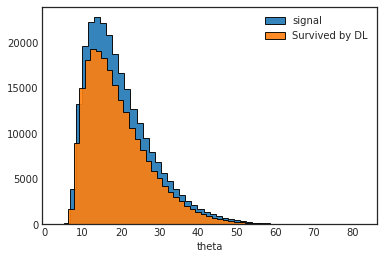

In [47]:
# draw theta
# - theta in the input data is already scaled by 1./90, put it back while plotting
plt.style.use('seaborn-white')
plt.title("Theta with DL response")

theta_train=extraVars_train[ : ,1:2]
scale=90

kwargs = dict(histtype='stepfilled', alpha=0.9, density=False, bins=50, ec="k")
plt.hist(theta_train[ tag_train==0 ] * scale, **kwargs, label="Background")
plt.hist(theta_train[ (tag_train==0) & (preds_train<DL_cut) ] * scale, **kwargs, label="Rejected by DL")
plt.xlabel("theta")
plt.legend(loc = 'upper right')
plt.show()
file_path=base_dir+"/plot/bg_theta_" + prefix +".pdf" 
fig.savefig(file_path)

plt.hist(theta_train[ tag_train==1 ] * scale, **kwargs, label="signal")
plt.hist(theta_train[ (tag_train==1) & (preds_train>DL_cut) ] * scale, **kwargs, label="Survived by DL")
plt.xlabel("theta")
plt.legend(loc = 'upper right')
plt.show()
file_path=base_dir+"/plot/sig_theta_" + prefix + ".pdf" 
fig.savefig(file_path)